# Projet 2 Participez à un concours sur la Smart City

## Jupyter Notebook

Nous utilisons ce programme, qui est un outil informatique de logiciel libre, qui est basé sur IPython. Il vous permettra de lire les commentaires écrit au format markdown, et d'interpréter les cellules de code, ici en Python. Mais cette technologie marche avec d'autres langages, Scala par exemple.

## Pandas

Nous utiliserons le langage Python, conformément à la consigne, et nous importerons la bibliothèque de manipulation de données Pandas. Ensuite nous importerons Numpy pour travailler avec des matrices.

In [341]:
import pandas as pd
import pandasql as ps
import openpyxl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import math
import random
import itertools
from sklearn import preprocessing
import christofides

# 1) Présentation générale du jeu de données

## Data requirements

La ville de Paris veut optimiser ses tournées, il s'agit d'un problème d'algorithmie courant : ***Problème du voyageur de commerce***. Aujourd'hui ce calcul peut s'effectuer avec plusieurs millions de ville sans que cela ne prenne trop de temps de calcul. La ville de Paris met à notre disposition les positions de chaque emplacement et leur nom, de sorte que si nous considérons que le réseau de Paris est assez dense pour que nous puissions négliger les sinuosités de la route, nous pouvons calculer la distance à vol d'oiseau, entre les emplacements. Et en prenant l'emplacement le plus proche de l'emplacement ou nous sommes, nous pouvons espérer trouver ainsi le plus court chemin pour parvenir à notre objectif de tournée.

## Data collection

Nous récupérons les données depuis une seule source, un fichier "comma separator value" ou csv, [à cette adresse](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/AI+Engineer/Project+2+Participez+%C3%A0+un+concours+sur+la+Smart+City/p2-arbres-fr.csv). Nous plaçons ensuite le fichier dans le répertoire de travail pour l'importer dans la partie suivante. Ce jeu de données comporte $17$ colonnes. $200137$ lignes et $646164$ valeurs manquantes. La colonne numéro est inutilisable, et celle des id ne démarre pas à *0*. Plus d'information seront détaillées dans les paragraphes suivants.

## Data processing

Nous obtenons les données dans le bon format, mais avec quelques erreurs, nous verrons cela plus tard, pour l'instant nous importons nos données en indiquant le séparateur, et la colonne servant à indexer la table de nos données. Nous remplaçons la colonne d'indexation par un index à l'itération parfaite. Nous éliminons les colonnes id et numero qui ne sont pas intéressante pour nos observations.

In [2]:
data = pd.read_csv('data.csv', sep=';')
data.drop('id', axis=1, inplace=True)
data.drop('numero', axis=1, inplace=True)

## Data cleaning

Nous devons contrôler les doublons, les valeurs nulles, les données incomplètes, les erreurs et les données manquantes. Nous réglons les types, pour obtenir des valeurs à mettre en base de données, au besoin.
Voilà comment se présentent les données sorties du fichier.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200137 entries, 0 to 200136
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   type_emplacement     200137 non-null  object 
 1   domanialite          200136 non-null  object 
 2   arrondissement       200137 non-null  object 
 3   complement_addresse  30902 non-null   object 
 4   lieu                 200137 non-null  object 
 5   id_emplacement       200137 non-null  object 
 6   libelle_francais     198640 non-null  object 
 7   genre                200121 non-null  object 
 8   espece               198385 non-null  object 
 9   variete              36777 non-null   object 
 10  circonference_cm     200137 non-null  int64  
 11  hauteur_m            200137 non-null  int64  
 12  stade_developpement  132932 non-null  object 
 13  remarquable          137039 non-null  float64
 14  geo_point_2d_a       200137 non-null  float64
 15  geo_point_2d_b   

#### Les valeurs nulles, les types.

Nous remplaçons les valeurs nulles de la colonne "remarquable" par la valeur 0 (qui code pour False), et nous pouvons remplacer le type par un booléen après avoir échanger les valeurs flottantes par des booleénnes.

In [4]:
data['remarquable'].fillna(value=0, inplace=True)
data['remarquable'] = data['remarquable'].map({0.:False, 1.:True})
data['remarquable'] = data['remarquable'].convert_dtypes()

Pour les colonnes "arrondissement"…, qui n'ont pas de valeurs nulles, nous forçons la conversion

In [5]:
colonnes = ['arrondissement', 'type_emplacement', 'lieu', 'id_emplacement']
for col in colonnes:
    data[col] = data[col].convert_dtypes(convert_string=True)

Pour les colonnes "stade_developpement"…, comme ce sont des strings, nous remplaçons les valeurs nulles par deux quote.

In [6]:
colonnes = ['stade_developpement', 'espece', 'variete', 'genre', 'libelle_francais',\
            'complement_addresse', 'domanialite']
for col in colonnes:
    data[col].fillna(value="", inplace=True)
    data[col] = data[col].convert_dtypes(convert_string=True)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200137 entries, 0 to 200136
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   type_emplacement     200137 non-null  string 
 1   domanialite          200137 non-null  string 
 2   arrondissement       200137 non-null  string 
 3   complement_addresse  200137 non-null  string 
 4   lieu                 200137 non-null  string 
 5   id_emplacement       200137 non-null  string 
 6   libelle_francais     200137 non-null  string 
 7   genre                200137 non-null  string 
 8   espece               200137 non-null  string 
 9   variete              200137 non-null  string 
 10  circonference_cm     200137 non-null  int64  
 11  hauteur_m            200137 non-null  int64  
 12  stade_developpement  200137 non-null  string 
 13  remarquable          200137 non-null  boolean
 14  geo_point_2d_a       200137 non-null  float64
 15  geo_point_2d_b   

#### Construire une table d'information personnalisée

Il est possible de se passer de la méthode info pour construire un algorithme plus puissant afin d'observer le plus d'information sur les tables :

In [8]:
def informations(data):
    # Header
    print('{:^3}{:<1}{:^20}{:<1}{:^9}{:>1}{:^6}{:<1}{:^15}{:<1}{:^7}{:<1}{:^7}{:<1}'.format('#' , '|' , 'Column', '|', 'Dtype', '|', 'Unique', '|', 'Count Non-Null','|','Mean','|','Std','|'))
    print('{:^3}{:<1}{:^20}{:<1}{:^9}{:>1}{:^6}{:<1}{:^15}{:<1}{:^7}{:<1}{:^7}{:<1}'.format('---' , '|' , '------', '|', '-----', '|', '------', '|', '--------------','|','----','|','---','|'))
    # dtypes information
    dtypes_uniques = set() # Collection of unique elements
    dtypes_listes = [] # list of complete data columns
    memory_usage = 0 # in MB
    for it, col in enumerate(data.columns): # Feed the set and the list
        dtypes_listes.append(str(data[col].dtype))
        if str(data[col].dtype) not in dtypes_uniques:
            dtypes_uniques.add(str(data[col].dtype))
        # Table body
        print('{:^3}{:<1}{:<20}{:<1}{:^9}{:>1}{:<6}{:<1}{:<15}{:<1}{:<7.5}{:<1}{:<7.5}{:<1}'.format(\
                                                str(it), '|' , col, '|',\
                                                str(data[col].dtype), '|', str(len(data[col].unique())),\
                                                '|',str(data[col].count()) + ' Non-null','|',\
                                                str(data[col].mean())\
                                                    if (data[col].dtype in ['int64','float64']) else '','|',\
                                                str(data[col].std())\
                                                    if (data[col].dtype in ['int64','float64']) else '','|'))
        
        # Collect informatives on disk usage by observation onto the data column
        memory_usage += int(data[col].memory_usage(index=True, deep=False))
    # Blend of set and list to print the information line as usual
    dtypes_string = ''
    for x in dtypes_uniques:
        dtypes_string += '{}({}), '.format(x, dtypes_listes.count(x))
    print('\ndtypes: {}'.format(dtypes_string))
    # Digit format to write mem usage in comprehensive format
    print('\nmemory usage: {:.4} MB\n'.format(memory_usage / (1024*1024)))

In [9]:
informations(data)

 # |       Column       |  Dtype  |Unique|Count Non-Null | Mean  |  Std  |
---|       ------       |  -----  |------|-------------- | ----  |  ---  |
 0 |type_emplacement    | string  |1     |200137 Non-null|       |       |
 1 |domanialite         | string  |10    |200137 Non-null|       |       |
 2 |arrondissement      | string  |25    |200137 Non-null|       |       |
 3 |complement_addresse | string  |3796  |200137 Non-null|       |       |
 4 |lieu                | string  |6921  |200137 Non-null|       |       |
 5 |id_emplacement      | string  |69040 |200137 Non-null|       |       |
 6 |libelle_francais    | string  |193   |200137 Non-null|       |       |
 7 |genre               | string  |176   |200137 Non-null|       |       |
 8 |espece              | string  |540   |200137 Non-null|       |       |
 9 |variete             | string  |437   |200137 Non-null|       |       |
10 |circonference_cm    |  int64  |531   |200137 Non-null|83.38  |673.1  |
11 |hauteur_m           |

# 2) Démarche méthodologique d'analyse de données

## Analyse univarée

Notre analyse va nous servir à détecter les erreurs dans la base de données, qui sont autant anomalies ("outliers") ou de données aberrantes qui peuvent nous conduire à de fausses conclusions sur les éléments de notre analyse. Nous analyserons les colonnes circonférence en centimètre, et hauteur en mètre. Les ordres de grandeurs sont indiqués dans les lignes min/max du tableau ci-dessous. À noter que nous commençons d'abord par décrire les données sans filtres :

In [10]:
data[['circonference_cm','hauteur_m']].describe()

,circonference_cm,hauteur_m
count,200137.000000,200137.000000
mean,83.380479,13.110509
std,673.190213,1971.217387
min,0.000000,0.000000
25%,30.000000,5.000000
50%,70.000000,8.000000
75%,115.000000,12.000000
max,250255.000000,881818.000000


### Intervalle interquartile

$Q_i = Q_3 - Q_1$ nous donne l'intervalle interquartile. L'intervalle minimum de confiance est $Q_i \times 1.5$, c'est la limite intérieur. De plus l'intervalle maximum de confiance est $Q_i \times 3$. Nous réglons nos bornes selon cette formule : pour la circonférence le maximum est $255$, alors que pour la hauteur le maximum est $21$.

Ci-dessus, la ligne max nous permet de raisonner sur la présence d'aberrations et dans les prochains paragraphes, en ajustant les valeurs d'exclusions en multipliant par 3,5 , nous allons faire une analyse univariée pour la circonférence et la hauteur des arbres de la ville de Paris. Nous avons pris la circonférence entre $]0, 255] centimètres$, la hauteur entre $]0, 21] mètres$, puis les remarquables avec une valeur Vrai (dans un cas spécialement adapté ou la corrélation est évaluée entre la hauteur et la circonférence).

### La circonférence

D'après le graphique et les résultats qui suivent, la circonférence de la population est une distribution dont le maximum est de $400 cm$ pour une moyenne de 91 cm et un écart type de $57,59 cm$ de part et d'autre de la moyenne. L'allure et la répartition de la distribution de la population est une asymétrie vers la droite, et le plus fréquemment, la circonférence est de 20 cm. L'échantillon considéré est de $174026$ arbres.

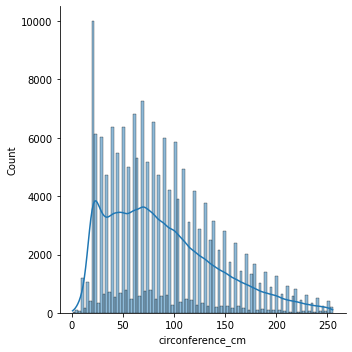

In [11]:
a = data.loc[(data["circonference_cm"] <= 255) & (data["circonference_cm"] > 0)]
sns.displot(data=a, x="circonference_cm", kde=True)

In [12]:
a["circonference_cm"].describe()

count    171801.000000
mean         88.451965
std          52.976410
min           1.000000
25%          45.000000
50%          80.000000
75%         120.000000
max         255.000000
Name: circonference_cm, dtype: float64

In [13]:
a["circonference_cm"].mode()

0    20
dtype: int64

In [14]:
scipy.stats.skew(a["circonference_cm"], axis=0, bias=True, nan_policy='propagate')

0.7695227895406083

In [15]:
scipy.stats.kurtosis(a["circonference_cm"], axis=0, bias=True, nan_policy='propagate')

0.027890140940736163

### La hauteur

La distribution est irrégulière, mais contient $160122$ arbres après filtrage des données aberrantes. La hauteur maximale est $29 mètres$ et la moyenne est de $10,32 mètres$, tout comme le mode et la médiane. Par contre l'asymétrie est positive, donc vers la droite mais sa valeur est inférieur à $1$, comme l'est aussi son kurtosis. Visuellement, il serait difficile de dire qu'ici s'applique le théorème de limite centrale car nous n'avons pas a première vue une Gaussienne.


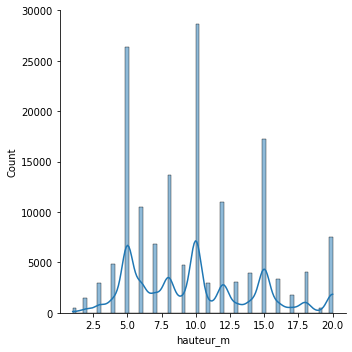

In [16]:
b = data.loc[(data["hauteur_m"] < 21) & (data["hauteur_m"] > 0)]
sns.displot(data=b, x="hauteur_m", kde=True)

In [17]:
b["hauteur_m"].describe()

count    155743.000000
mean          9.928016
std           4.546542
min           1.000000
25%           6.000000
50%          10.000000
75%          13.000000
max          20.000000
Name: hauteur_m, dtype: float64

In [18]:
b["hauteur_m"].mode()

0    10
dtype: int64

In [19]:
scipy.stats.skew(b["hauteur_m"], axis=0, bias=True, nan_policy='propagate')

0.4872105232672621

In [20]:
scipy.stats.kurtosis(b["hauteur_m"], axis=0, bias=True, nan_policy='propagate')

-0.6014377033875058

### Régression linéaire

En considérant l'expression de la circonférence d'après la hauteur, nous pouvons constater une corrélation positive entre le données quantitative, autant pour les arbres remarquables, que les premiers.

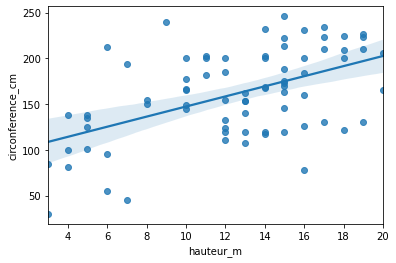

In [21]:
sns.regplot( x="hauteur_m", y="circonference_cm", data=data.loc[((data["hauteur_m"] < 21) & (data["hauteur_m"] > 0)) \
                          & ((data["circonference_cm"] < 255) & (data["circonference_cm"] > 0)) & (data["remarquable"] == True)]);

<AxesSubplot:xlabel='haut', ylabel='circon'>

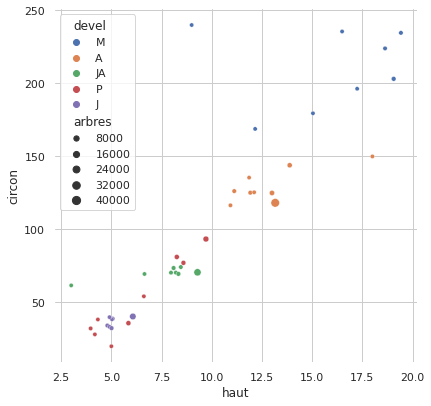

In [188]:
sns.set_theme(style="whitegrid")

df = quant_dev_dom[['haut','circon', 'arbres', 'devel']]

f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
clarity_ranking = ['M','A','JA','P','J']
sns.scatterplot(x="haut", y="circon",
                hue="devel", hue_order=clarity_ranking,
                size="arbres",
                data=df, ci="sd",ax=ax)

<AxesSubplot:xlabel='circon', ylabel='haut'>

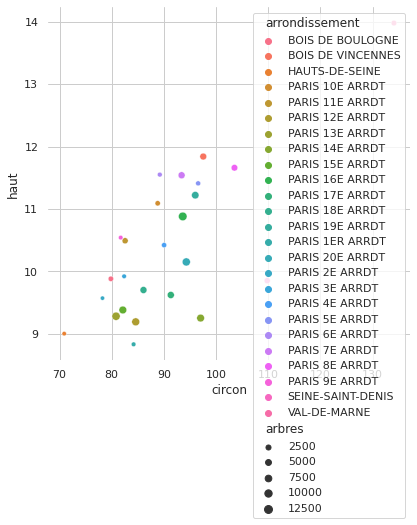

In [202]:
sns.set_theme(style="whitegrid")

df = quant_arr[['haut','circon', 'arbres', 'arrondissement']]

f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
#clarity_ranking = ['M','A','JA','P','J']
sns.scatterplot(x="circon", y="haut",
                hue="arrondissement", #hue_order=clarity_ranking,
                size="arbres",
                data=df, ci="sd",ax=ax)

Si nous ajoutons les variables indépendantes circonférence, hauteur pour les arbres remarquables, nous pourrions sans doute appliquer le théorème de limite centrale sur nos données ainsi filtrés tant les courbes ont une forme dont la régularité s'approche plus d'une gaussienne. Peut-être nous restera-t-il à croiser les données avec d'autres pour affiner la courbe en forme de cloche.

In [23]:
c = data.loc[((data["hauteur_m"] < 30) & (data["hauteur_m"] > 0)) \
                          & ((data["circonference_cm"] < 400) & (data["circonference_cm"] > 0)) & data["remarquable"] == True]

In [24]:
c[["hauteur_m","circonference_cm"]].describe()

,hauteur_m,circonference_cm
count,135.000000,135.000000
mean,16.585185,225.629630
std,6.557877,90.137601
min,3.000000,30.000000
25%,12.000000,155.000000
50%,16.000000,213.000000
75%,22.000000,294.500000
max,28.000000,397.000000


Pour la circonférence des arbres remarquables, le plus fréquemment, elle vaut $200 cm$ et $15 m$ pour la hauteur.

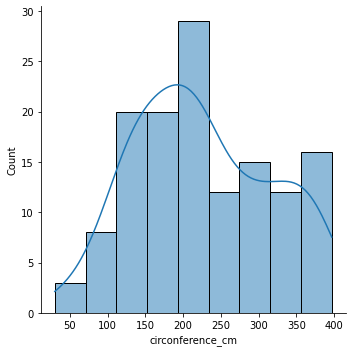

In [25]:
sns.displot(data=c, x="circonference_cm", kde=True)

In [26]:
c["circonference_cm"].mode()

0    200
dtype: int64

In [27]:
scipy.stats.skew(c["circonference_cm"], axis=0, bias=True, nan_policy='propagate')

0.20157008682044858

In [28]:
scipy.stats.kurtosis(c["circonference_cm"], axis=0, bias=True, nan_policy='propagate')

-0.8788778036417639

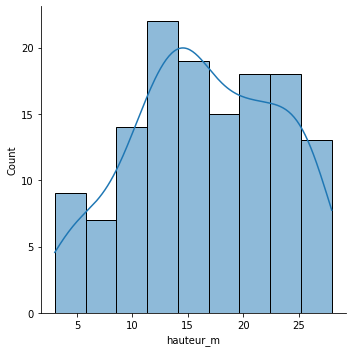

In [29]:
sns.displot(data=c, x="hauteur_m", kde=True)

La description des valeurs du graphique ci-dessus est donnée ci-dessous. Elle nous permet de comparer **les ordres de grandeur** entre les colonnes.

In [30]:
c["hauteur_m"].mode()

0    15
dtype: int64

In [31]:
scipy.stats.skew(c["hauteur_m"], axis=0, bias=True, nan_policy='propagate')

-0.13664641352746662

In [32]:
scipy.stats.kurtosis(c["hauteur_m"], axis=0, bias=True, nan_policy='propagate')

-0.8606700137295262


## Analyse Quantitative

Nous utilisons un filtre sur la base pour éliminer les arbres dont nous ne sommes pas sur de la hauteur ou de la circonférence, puis avec une requête SQL, nous déterminons le nombre d'individu, dans chaque élément quantitatif à l'intérieur de chaque quartier, excepté pour la domanialité qui est une données de catégorie. Nous ajoutons en plus des moyennes ainsi que des pourcentages du nombre d'arbres. Nous commençons notre analyse quantitative sur $159568$ arbres.

In [293]:
data_filtered = data.loc[((data["hauteur_m"] < 30) & (data["hauteur_m"] > 0)) \
                          & ((data["circonference_cm"] < 400) & (data["circonference_cm"] > 0))].copy()

De plus nous remarquons qu'une ligne ne comporte pas de domanialité, mais qu'il semble d'après son lieu, que ce soit un jardin.

In [294]:
data_filtered.loc[data_filtered['domanialite'] == ""]

,type_emplacement,domanialite,arrondissement,complement_addresse,lieu,id_emplacement,libelle_francais,genre,espece,variete,circonference_cm,hauteur_m,stade_developpement,remarquable,geo_point_2d_a,geo_point_2d_b
197239,Arbre,,PARIS 20E ARRDT,,JARDINS D IMMEUBLES PORTE DE VINCENNES NORD / ...,203006,Chimonanthe,Chimonanthus,praecox,,35,4,JA,False,48.849547,2.41419


In [295]:
mask = data_filtered['domanialite'] == ''
data_filtered.loc[mask,'domanialite'] = 'Jardin'

In [296]:
data_filtered.loc[data_filtered['domanialite'] == ""]

,type_emplacement,domanialite,arrondissement,complement_addresse,lieu,id_emplacement,libelle_francais,genre,espece,variete,circonference_cm,hauteur_m,stade_developpement,remarquable,geo_point_2d_a,geo_point_2d_b


De même pour la variété, pour 63000 arbres :

In [297]:
mask = data_filtered['variete'] == ''
data_filtered.loc[mask,'variete'] = 'n. sp.'
mask = data_filtered['espece'] == ''
data_filtered.loc[mask,'espece'] = 'n. sp.'

De plus pour la légende des stades de développement, nous rajoutons la P, pour particulier, car il représente une masse d'arbre qui sorte des statistiques pour la moitié d'entre eux. Cette catégorie passe de 60000 arbres à 30000 arbres après filtrage des hauteurs et des circonférences. Cette catégorie semble regroupé des arbres de catégories JA et J.

In [298]:
data_filtered.stade_developpement = data_filtered.stade_developpement.map({'':'P', 'A':'A','JA':'JA','M':'M','J':'J'})

Comme la colonne de stade de développement est une variable qualitative ordonnée, nous créons une colonne de sa valeur en chiffre pour un usage quantitatif de la variable car l'âge est quantitatif.

In [301]:
data_filtered['maturite'] = data_filtered.stade_developpement.map({'P':2, 'A':4,'JA':3,'M':5,'J':1})

In [302]:
count_before_filtering = data['type_emplacement'].loc[data.stade_developpement == ''].count()
count_after_filtering = data_filtered['type_emplacement'].loc[data_filtered.stade_developpement == 'P'].count()
print('Avant : ', count_before_filtering, 'arbres, Après filtrage : ', count_after_filtering, 'arbres')

Avant :  67205 arbres, Après filtrage :  29853 arbres


In [121]:
q1 = """SELECT  arrondissement,
                ROUND(Count(type_emplacement)* 100. / (Select Count(type_emplacement) From data), 2) as "pourcent",
                count(DISTINCT(domanialite)) as domani,
                count(DISTINCT(lieu)) as lieu,
                count(type_emplacement) as arbres,
                count(DISTINCT(id_emplacement)) as id_empl,
                count(DISTINCT(libelle_francais)) as libel_fr,
                count(DISTINCT(genre)) as genre,
                count(DISTINCT(espece)) as espece,
                count(DISTINCT(variete)) as variete,
                ROUND(AVG(circonference_cm),2) as circon,
                ROUND(AVG(hauteur_m),2) as haut,
                SUM(remarquable) as remarq
                FROM data_filtered GROUP BY data_filtered.arrondissement"""

In [122]:
quant_arr = ps.sqldf(q1, locals())

In [123]:
quant_arr

,arrondissement,pourcent,domani,lieu,arbres,id_empl,libel_fr,genre,espece,variete,circon,haut,remarq
0,BOIS DE BOULOGNE,1.64,2,18,3274,1777,25,21,43,24,79.84,9.88,0
1,BOIS DE VINCENNES,4.03,2,26,8057,4681,94,83,154,42,97.55,11.84,0
2,HAUTS-DE-SEINE,0.45,1,184,894,894,33,28,42,19,70.89,9.00,0
3,PARIS 10E ARRDT,1.55,5,119,3099,1618,59,43,75,66,88.81,11.09,1
4,PARIS 11E ARRDT,2.74,5,176,5474,2377,90,71,110,76,82.57,10.49,1
5,PARIS 12E ARRDT,6.02,9,292,12046,5310,101,81,171,94,84.60,9.19,15
6,PARIS 13E ARRDT,6.77,7,346,13541,5227,114,95,188,121,80.83,9.28,4
7,PARIS 14E ARRDT,5.65,7,330,11314,6275,113,99,180,130,97.04,9.25,8
8,PARIS 15E ARRDT,5.70,8,307,11412,4866,98,81,153,113,82.13,9.38,7
9,PARIS 16E ARRDT,7.47,7,276,14944,5611,121,107,212,133,93.62,10.88,37


Nous faisons la même chose pour chaque domanialité :

In [192]:
q2 = """SELECT  domanialite,
                ROUND(Count(type_emplacement)* 100. / (Select Count(type_emplacement) From data),2) as "pourcent",
                count(DISTINCT(arrondissement)) as arrond,
                count(DISTINCT(stade_developpement)) as devel,
                count(DISTINCT(lieu)) as lieu,
                count(type_emplacement) as arbres,
                count(DISTINCT(id_emplacement)) as id_empl,
                count(DISTINCT(libelle_francais)) as libel_fr,
                count(DISTINCT(genre)) as genre,
                count(DISTINCT(espece)) as espece,
                count(DISTINCT(variete)) as variete,
                ROUND(AVG(circonference_cm),2) as circon,
                ROUND(AVG(hauteur_m),2) as haut,
                SUM(remarquable) as remarq
                FROM data_filtered GROUP BY data_filtered.domanialite"""

In [193]:
quant_dom = ps.sqldf(q2, locals())

In [194]:
quant_dom

,domanialite,pourcent,arrond,devel,lieu,arbres,id_empl,libel_fr,genre,espece,variete,circon,haut,remarq
0,Alignement,49.68,22,5,1796,99427,7639,97,80,168,125,88.21,10.50,8
1,CIMETIERE,8.47,10,5,1914,16945,14143,125,104,176,102,112.40,10.97,10
2,DAC,0.01,5,4,5,21,21,12,10,10,4,116.05,9.38,1
3,DASCO,3.18,20,5,662,6365,6338,96,74,137,161,79.82,8.35,0
4,DASES,0.00,2,2,2,4,4,1,1,1,1,52.50,8.25,0
5,DFPE,0.63,19,5,229,1269,1268,85,67,108,51,81.48,8.42,0
6,DJS,1.83,16,5,103,3672,3661,101,85,153,87,94.58,9.03,1
7,Jardin,13.35,21,5,548,26711,12267,155,134,339,241,97.65,10.27,115
8,PERIPHERIQUE,2.58,9,5,198,5154,5148,62,55,89,29,79.36,8.66,0


Nous observons que le stade de développement peut indiquer une relation avec les produits à utiliser, donc nous utilisons le stade de développement comme pivot.

In [196]:
q3 = """SELECT  stade_developpement,
                ROUND(Count(type_emplacement)* 100. / (Select Count(type_emplacement) From data),2) as "pourcent",
                count(DISTINCT(arrondissement)) as arrond,
                count(DISTINCT(domanialite)) as domani,
                count(DISTINCT(lieu)) as lieu,
                count(type_emplacement) as arbres,
                count(DISTINCT(id_emplacement)) as id_empl,
                count(DISTINCT(libelle_francais)) as libel_fr,
                count(DISTINCT(genre)) as genre,
                count(DISTINCT(espece)) as espece,
                count(DISTINCT(variete)) as variete,
                ROUND(AVG(circonference_cm), 2) as circon,
                ROUND(AVG(hauteur_m), 2) as haut,
                SUM(remarquable) as remarq
                FROM data_filtered GROUP BY data_filtered.stade_developpement"""

In [197]:
quant_dev = ps.sqldf(q3, locals())

In [198]:
quant_dev

,stade_developpement,pourcent,arrond,domani,lieu,arbres,id_empl,libel_fr,genre,espece,variete,circon,haut,remarq
0,A,31.44,25,9,3499,62929,20134,132,114,243,142,122.14,13.08,51
1,J,13.19,25,7,2615,26391,10124,132,112,267,256,38.81,5.76,1
2,JA,17.26,25,8,2760,34535,10647,132,109,229,147,70.84,9.05,1
3,M,2.93,25,8,1094,5860,3650,72,64,105,38,213.69,18.84,80
4,P,14.92,25,9,2630,29853,17642,151,129,282,260,75.21,8.31,2


In [ ]:
quant_dom['haut_std']

Ici nous exprimons les quantités par stade de développement, et par domanialité

In [151]:
q4 = """SELECT  stade_developpement as devel,
                domanialite as domani,
                ROUND(Count(type_emplacement)* 100. / (Select Count(type_emplacement) From data), 2) as "pourcent",
                count(DISTINCT(arrondissement)) as arrond,
                count(DISTINCT(lieu)) as lieu,
                count(type_emplacement) as arbres,
                count(DISTINCT(id_emplacement)) as id_empl,
                count(DISTINCT(libelle_francais)) as libel_fr,
                count(DISTINCT(genre)) as genre,
                count(DISTINCT(espece)) as espece,
                count(DISTINCT(variete)) as variete,
                ROUND(AVG(circonference_cm),2) as circon,
                ROUND(AVG(hauteur_m),2) as haut,
                SUM(remarquable) as remarq
                FROM data_filtered GROUP BY data_filtered.stade_developpement, domanialite
                ORDER BY devel, domani, haut"""

In [152]:
quant_dev_dom = ps.sqldf(q4, locals())

In [153]:
quant_dev_dom

,devel,domani,pourcent,arrond,lieu,arbres,id_empl,libel_fr,genre,espece,variete,circon,haut,remarq
0,A,Alignement,22.10,22,1379,44238,5000,71,59,113,78,118.22,13.16,2
1,A,CIMETIERE,3.20,9,1028,6397,5824,81,71,97,40,143.95,13.88,5
2,A,DAC,0.01,3,3,14,14,7,7,6,3,135.50,11.86,0
3,A,DASCO,1.21,20,527,2431,2428,64,48,72,27,125.15,11.92,0
4,A,DASES,0.00,1,1,1,1,1,1,1,1,150.00,18.00,0
5,A,DFPE,0.25,16,132,493,493,47,38,58,19,116.53,10.93,0
6,A,DJS,0.88,15,91,1767,1765,56,48,78,26,126.25,11.12,1
7,A,Jardin,3.61,21,293,7220,5040,115,101,209,96,124.97,13.00,43
8,A,PERIPHERIQUE,0.18,8,51,368,368,29,25,35,7,125.44,12.11,0
9,J,Alignement,9.52,22,1151,19053,4018,81,65,130,90,40.39,6.07,0


In [360]:
q5 = """SELECT  genre,
                ROUND(Count(type_emplacement)* 100. / (Select Count(type_emplacement) From data),2) as "pourcent",
                count(DISTINCT(arrondissement)) as arrond,
                count(DISTINCT(domanialite)) as domani,
                count(DISTINCT(lieu)) as lieu,
                count(type_emplacement) as arbres,
                count(DISTINCT(id_emplacement)) as id_empl,
                count(DISTINCT(libelle_francais)) as libel_fr,
                count(DISTINCT(variete)) as variete,
                count(DISTINCT(espece)) as espece,
                ROUND(AVG(maturite), 2) as cat_age,
                ROUND(AVG(circonference_cm), 2) as circon,
                ROUND(AVG(hauteur_m), 2) as haut,
                SUM(remarquable) as remarq
                FROM data_filtered GROUP BY data_filtered.genre"""

In [361]:
quant_gen = ps.sqldf(q5, locals())

In [362]:
quant_gen

,genre,pourcent,arrond,domani,lieu,arbres,id_empl,libel_fr,variete,espece,cat_age,circon,haut,remarq
0,Abelia,0.00,2,2,2,2,2,1,1,2,3.00,47.50,5.50,0
1,Abies,0.04,15,4,26,71,71,1,1,8,2.35,65.72,8.32,0
2,Acacia,0.00,2,2,2,6,6,1,2,1,2.00,24.17,5.00,0
3,Acca,0.00,1,1,2,2,2,2,2,1,1.50,10.00,1.00,0
4,Acer,6.25,25,8,1402,12501,8386,2,47,36,2.91,90.11,10.10,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,Viburnum,0.00,2,1,3,3,3,1,1,1,1.67,30.00,5.00,0
142,Zanthoxylum,0.01,7,3,8,11,11,1,1,2,2.73,36.82,4.64,0
143,Zelkova,0.13,20,7,55,258,251,2,5,5,2.06,59.49,7.03,3
144,x Chitalpa,0.01,8,6,13,16,16,2,2,2,1.50,23.44,3.44,0


In [363]:
x = quant_gen[['haut','circon','cat_age','arbres']].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)


In [364]:
df = df.rename(columns={0:'haut',1:'circon',2:'cat_age',3:'arbres'})

In [365]:
quant_gen = df.merge(quant_gen['genre'], on=quant_tem.index)

In [376]:
quant_gen.drop('key_0',axis=1, inplace=True)

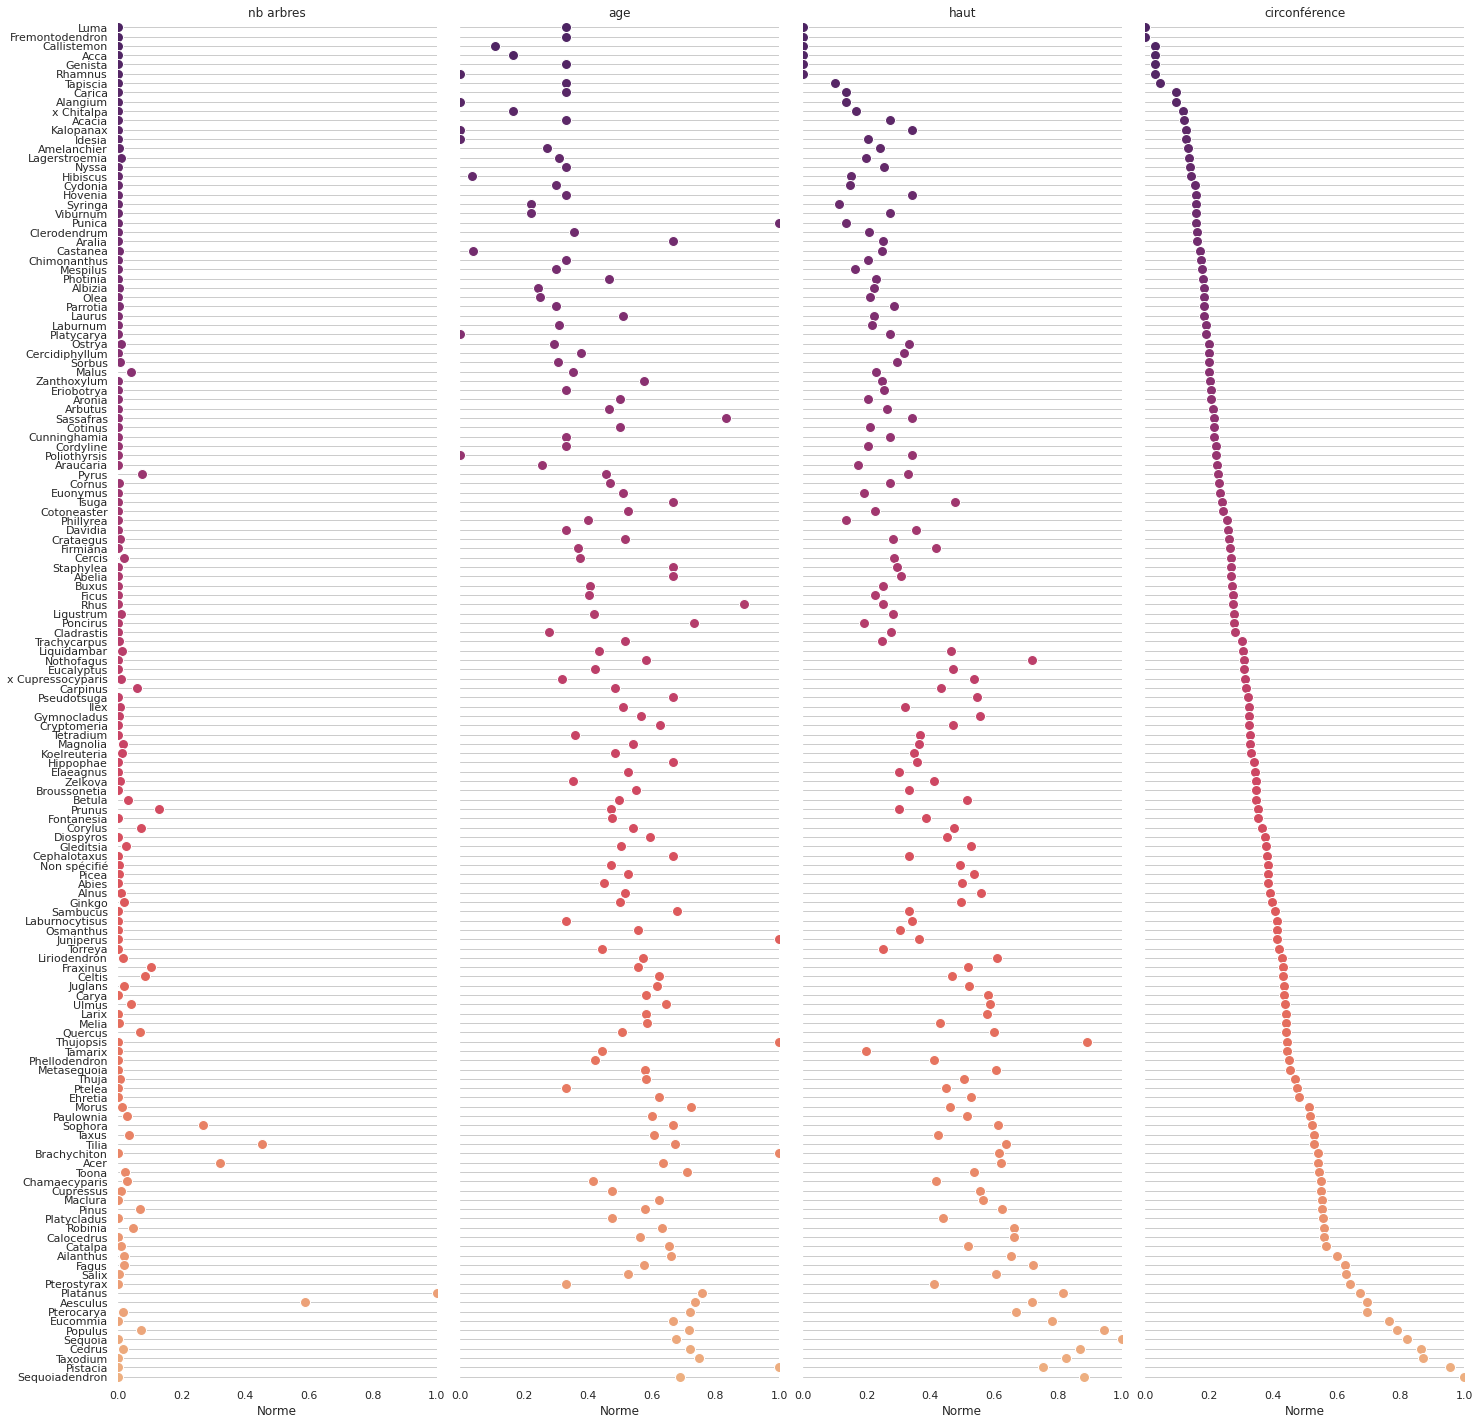

In [377]:
sns.set_theme(style="whitegrid")

# Load the dataset
crashes = quant_gen[['genre','arbres','cat_age','haut', 'circon']]#sns.load_dataset("car_crashes")

# Make the PairGrid
g = sns.PairGrid(crashes.sort_values("circon", ascending=True),
                 x_vars=crashes.columns[1:], y_vars=["genre"],
                 height=20, aspect=.25)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h", jitter=False,
      palette="flare_r", linewidth=1, edgecolor="w")

# Use the same x axis limits on all columns and add better labels
g.set(xlim=(0, 1), xlabel='Norme', ylabel="")

# Use semantically meaningful titles for the columns
titles = ['nb arbres','age','haut', 'circonférence']

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)
g.savefig("genre_circonf.png")


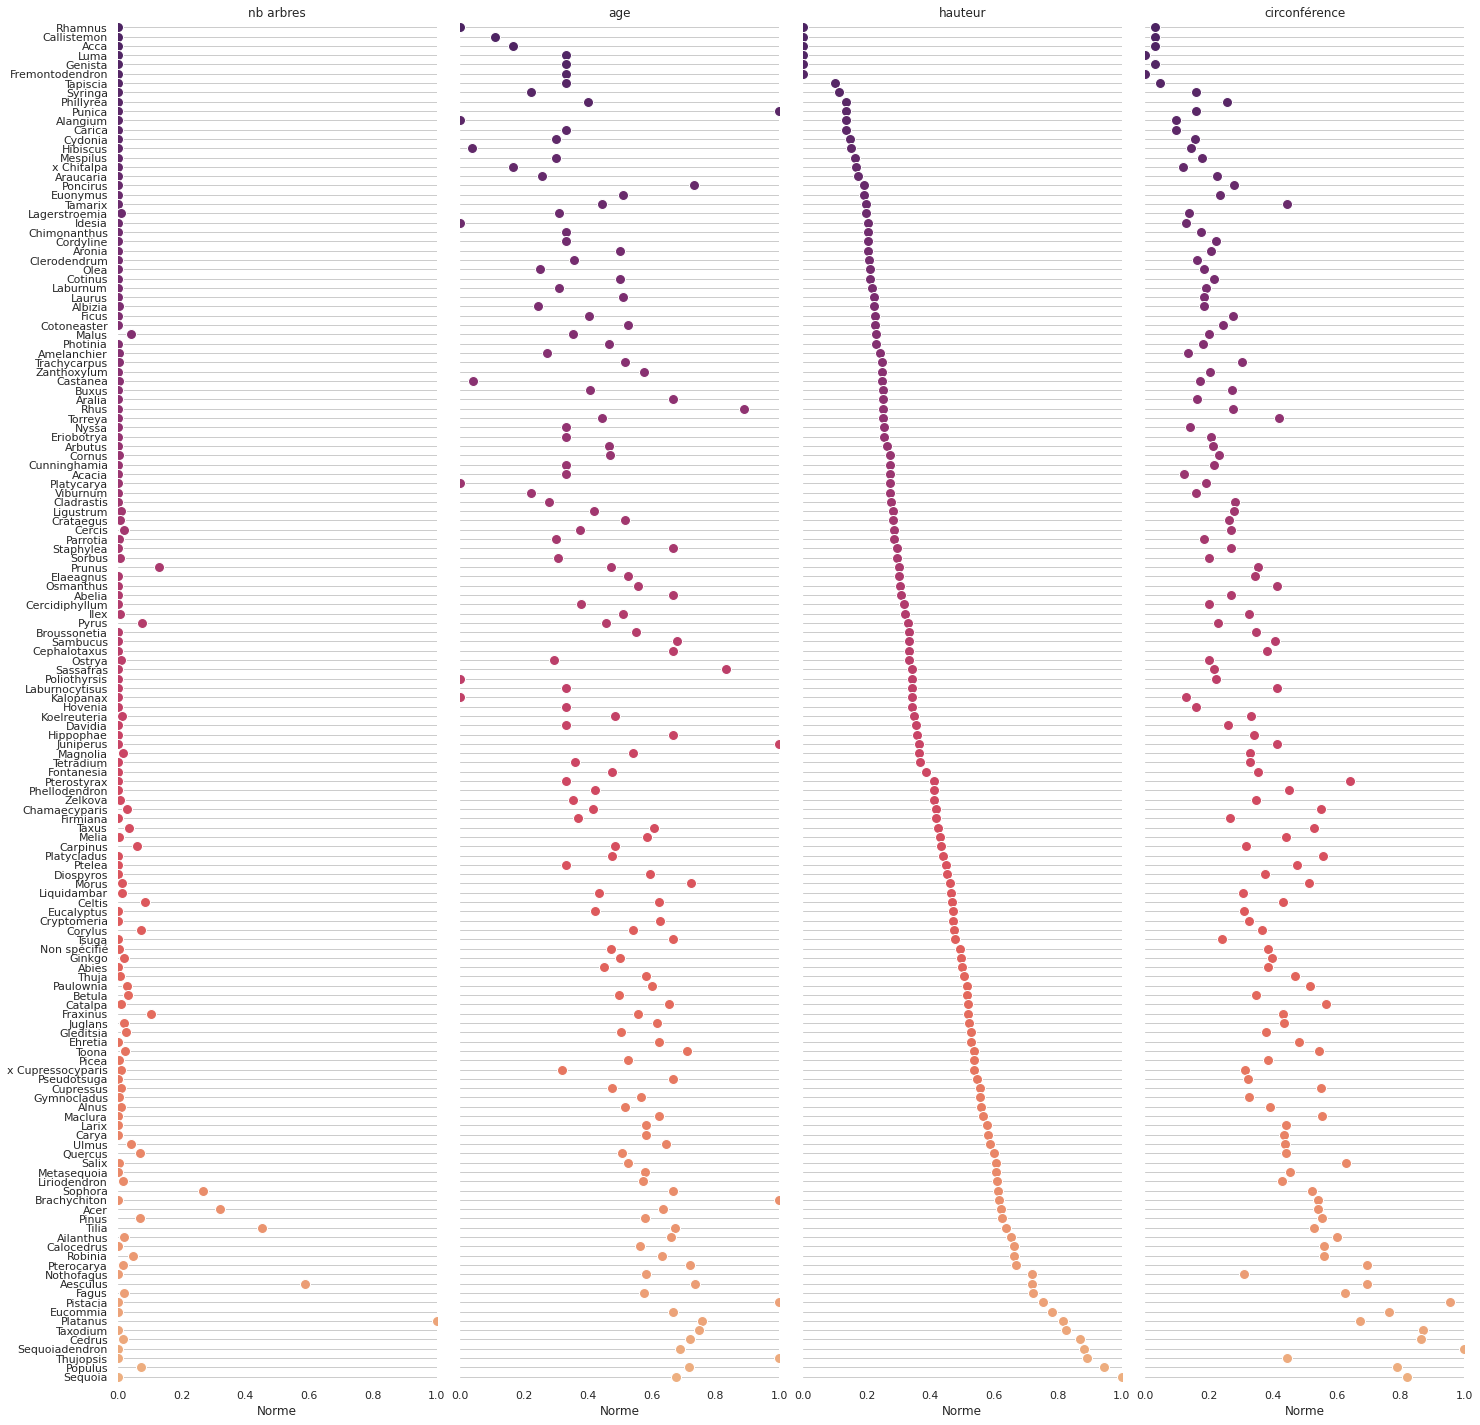

In [378]:
sns.set_theme(style="whitegrid")

# Load the dataset
crashes = quant_gen[['genre','arbres','cat_age','haut', 'circon']]#sns.load_dataset("car_crashes")

# Make the PairGrid
g = sns.PairGrid(crashes.sort_values("haut", ascending=True),
                 x_vars=crashes.columns[1:], y_vars=["genre"],
                 height=20, aspect=.25)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h", jitter=False,
      palette="flare_r", linewidth=1, edgecolor="w")

# Use the same x axis limits on all columns and add better labels
g.set(xlim=(0, 1), xlabel='Norme', ylabel="")

# Use semantically meaningful titles for the columns
titles = ['nb arbres','age','hauteur', 'circonférence']

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)
g.savefig("genre_hauteur.png")


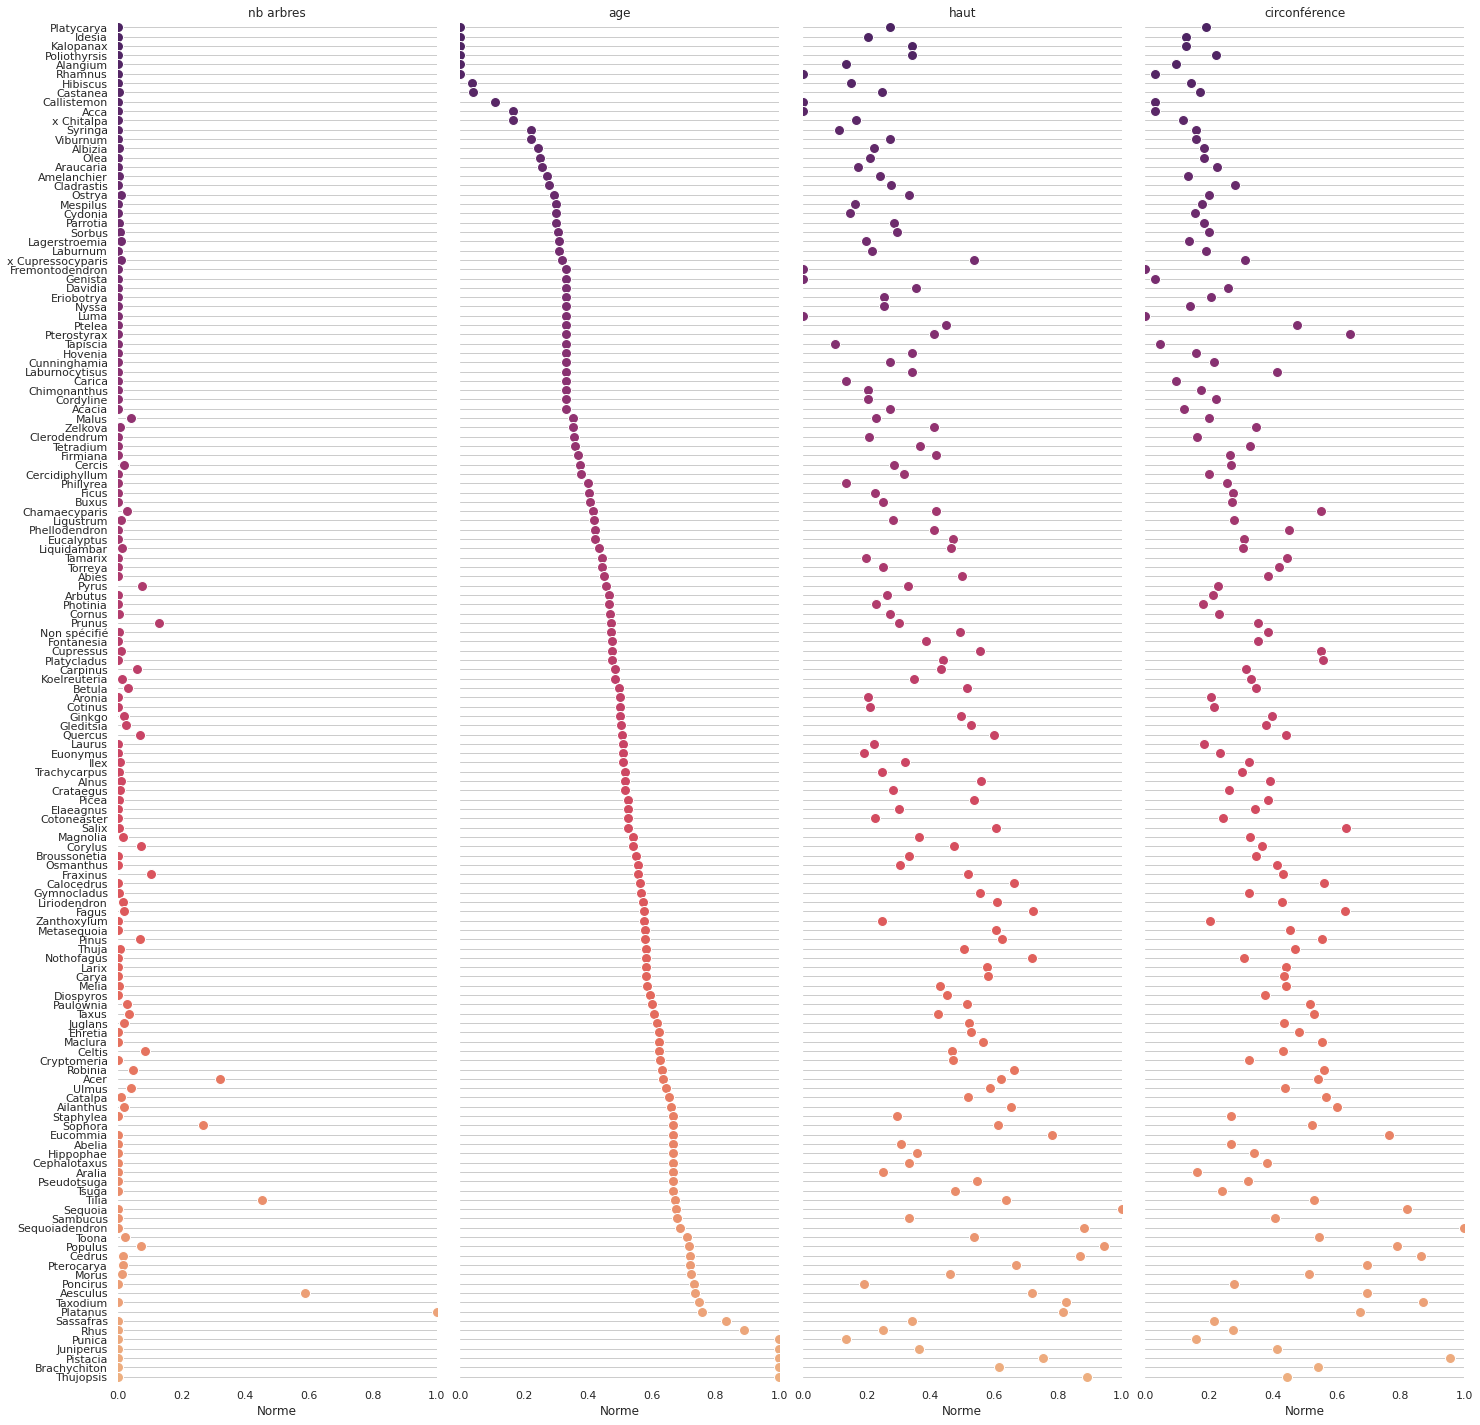

In [379]:
sns.set_theme(style="whitegrid")

# Load the dataset
crashes = quant_gen[['genre','arbres','cat_age','haut', 'circon']]#sns.load_dataset("car_crashes")

# Make the PairGrid
g = sns.PairGrid(crashes.sort_values("cat_age", ascending=True),
                 x_vars=crashes.columns[1:], y_vars=["genre"],
                 height=20, aspect=.25)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h", jitter=False,
      palette="flare_r", linewidth=1, edgecolor="w")

# Use the same x axis limits on all columns and add better labels
g.set(xlim=(0, 1), xlabel='Norme', ylabel="")

# Use semantically meaningful titles for the columns
titles = ['nb arbres','age','haut', 'circonférence']

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)
g.savefig("genre_age.png")


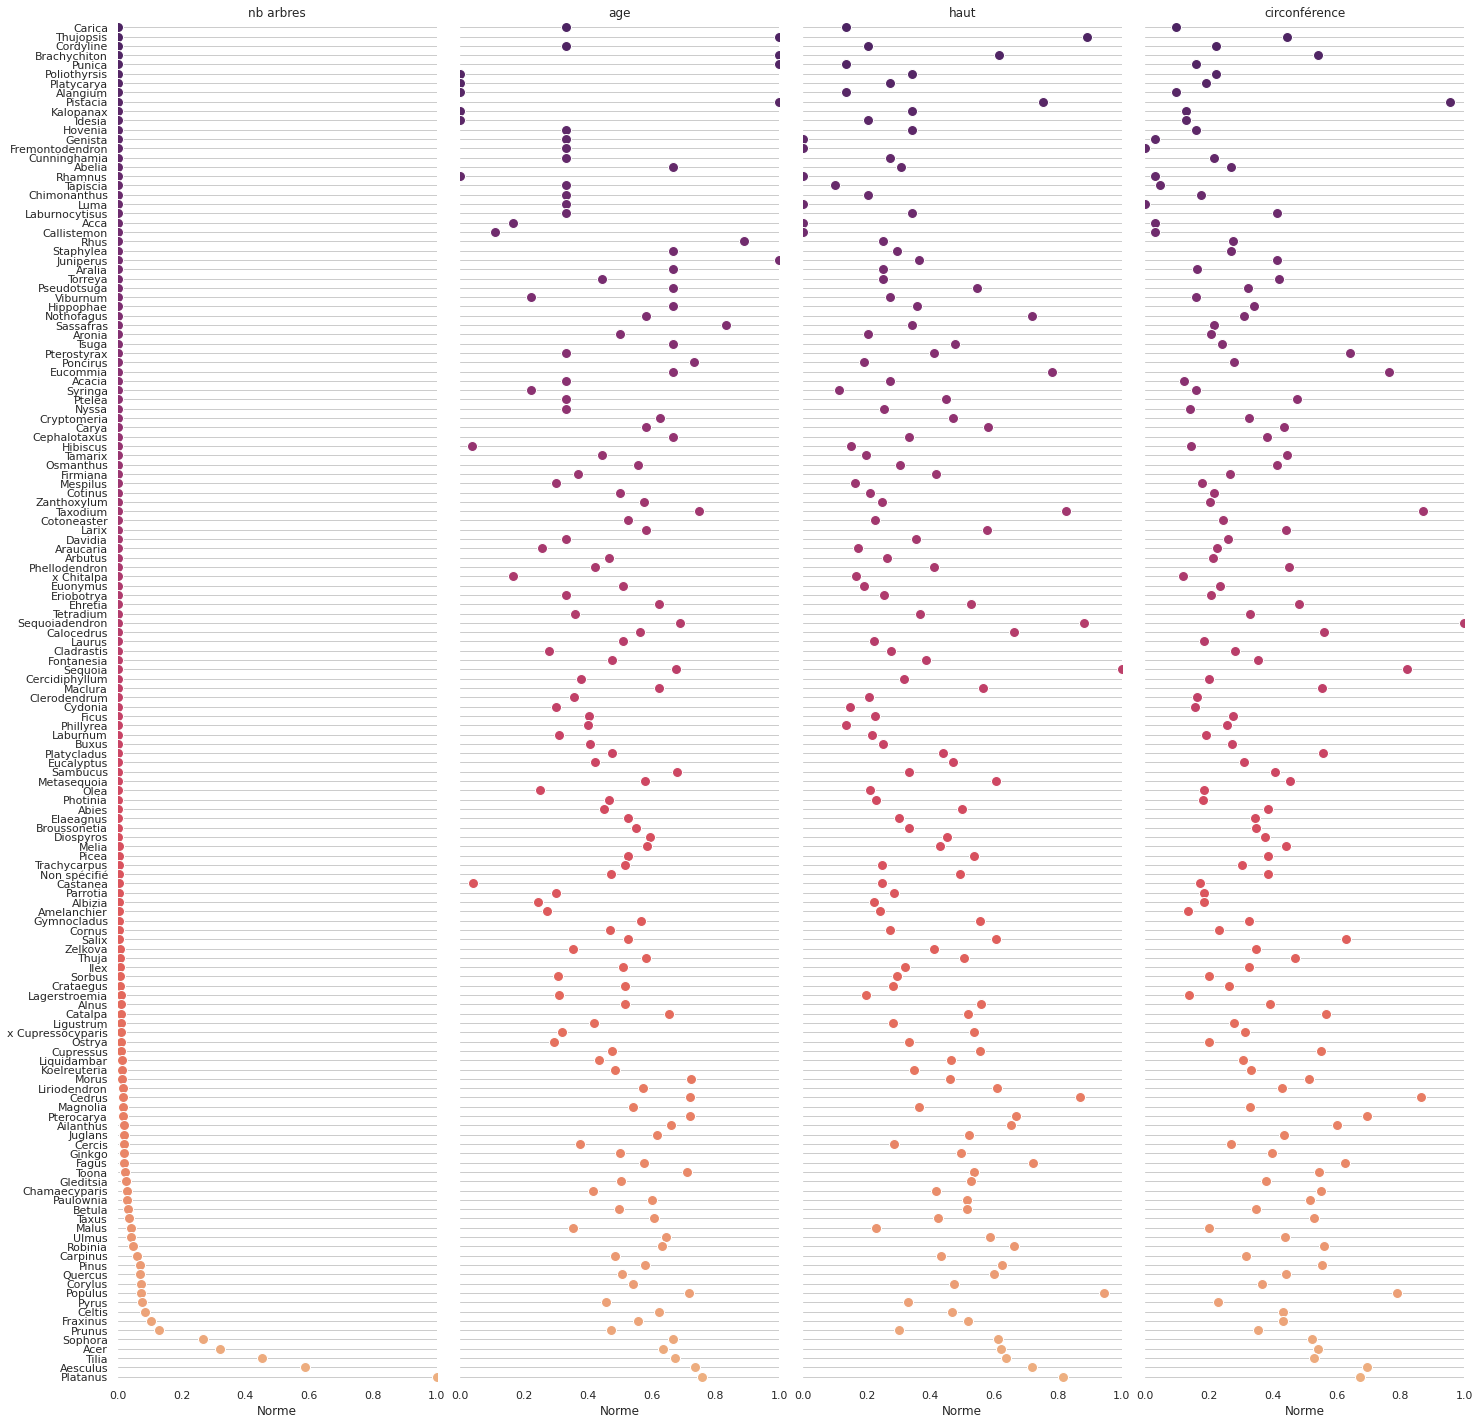

In [380]:
sns.set_theme(style="whitegrid")

# Load the dataset
crashes = quant_gen[['genre','arbres','cat_age','haut', 'circon']]#sns.load_dataset("car_crashes")

# Make the PairGrid
g = sns.PairGrid(crashes.sort_values("arbres", ascending=True),
                 x_vars=crashes.columns[1:], y_vars=["genre"],
                 height=20, aspect=.25)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h", jitter=False,
      palette="flare_r", linewidth=1, edgecolor="w")

# Use the same x axis limits on all columns and add better labels
g.set(xlim=(0, 1), xlabel='Norme', ylabel="")

# Use semantically meaningful titles for the columns
titles = ['nb arbres','age','haut', 'circonférence']

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)
g.savefig("genre_nb_arbres.png")


# 3) Synthèse de mon analyse

<AxesSubplot:xlabel='haut', ylabel='circon'>

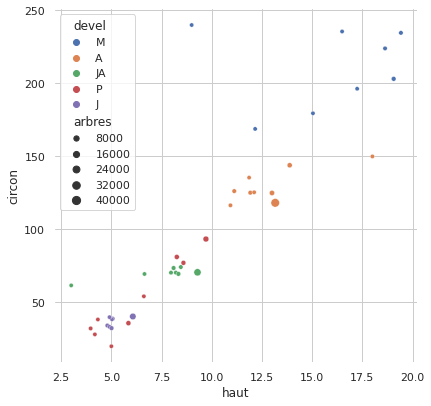

In [188]:
sns.set_theme(style="whitegrid")

df = quant_dev_dom[['haut','circon', 'arbres', 'devel']]

f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
clarity_ranking = ['M','A','JA','P','J']
sns.scatterplot(x="haut", y="circon",
                hue="devel", hue_order=clarity_ranking,
                size="arbres",
                data=df, ci="sd",ax=ax)

<AxesSubplot:xlabel='circon', ylabel='haut'>

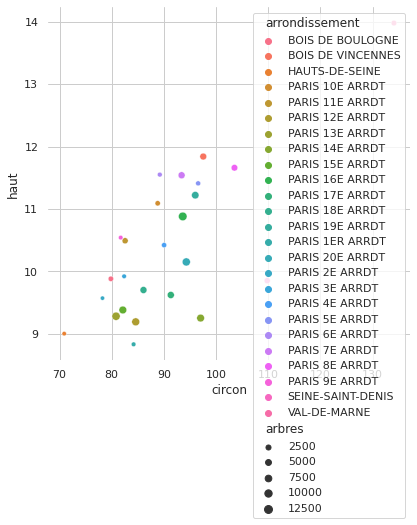

In [202]:
sns.set_theme(style="whitegrid")

df = quant_arr[['haut','circon', 'arbres', 'arrondissement']]

f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
#clarity_ranking = ['M','A','JA','P','J']
sns.scatterplot(x="circon", y="haut",
                hue="arrondissement", #hue_order=clarity_ranking,
                size="arbres",
                data=df, ci="sd",ax=ax)

# Partie Algorithmie, Optimisation des trajets

Nous avons réalisé une analyse exploratoire de nos données, à présent, nous allons tâcher de répondre à la problèmatique du meilleur trajet, qui est un problème similaire au problème du voyageur de commerce pour lequel nous souhaitons utiliser l'algorithme de [Christofides](https://fr.wikipedia.org/wiki/Algorithme_de_Christofides). Pour cela nous utiliserons un GPU en local, pour calculer les distances entre tous les lieux, et nous lancerons l'algorithme de recherche du plus court chemin entre tous les lieux soit $6921$ éléments distincts.

Nous devons suivre le schéma suivant pour construire l'algorithme de Christofides :



![Algorithme de Christofides](christofides.png)

## Calcul du meilleur trajet

### Calcul des distances entre chaque lieu

Nous relevons 200137 points d'intérêts sur la carte. Si nous descendons dans la structure hiérarchisé de nos données, nous comprenons qu'il s'agit geo_point_2d -> id_emplacement -> lieu + complement d'adresse -> lieu -> arrondissement. C'est à dire qu'un lieu regroupe des id_emplacement, i.e. des arbres.

Comme il s'agit de trouver une tournée véhiculée, entre $6921$ lieux uniques, contenant eux-mêmes un certain nombre d'arbres (chacun), et que ces lieux sont reliés entre eux par une distance pouvant se calculer d'après la latitude et la longitude, nous utiliserons une représentation en graphe (arrête et sommet) pour trouver le meilleurs chemins, en commençant par le calcul de la matrice des distances, puis du chemin de poids minimum.

1. Nous calculerons la quantité d'arbres d'un lieu par la fonction d'aggrégeage "aggfunc" ci-dessous. Nous disposerons le résultat dans une colonne portant le nom de aire, car c'est une donnée quantitative que nous souhaitons représenter sous la forme de cercle avec plus ou moins de surface.

In [ ]:
df = data[['arrondissement', 'lieu', 'geo_point_2d_a', 'geo_point_2d_b']]

In [ ]:
list(data.columns)

In [ ]:
q1 = """SELECT  arrondissement,
                count(DISTINCT(domanialite)) as domanialite,
                count(DISTINCT(lieu)) as lieu,
                count(type_emplacement) as arbres,
                count(DISTINCT(id_emplacement)) as id_empl,
                count(DISTINCT(libelle_francais)) as libel_fr,
                count(DISTINCT(genre)) as genre,
                count(DISTINCT(espece)) as espece,
                count(DISTINCT(variete)) as variete,
                count(remarquable == True) as remarq
                FROM data GROUP BY data.arrondissement"""

In [ ]:
ps.sqldf(q1, locals())

In [ ]:
lieu_aire = pd.DataFrame(df.pivot_table(index=['lieu'], aggfunc='size'), columns=['aire'])

In [ ]:
lieu_aire

**Nous éliminons ainsi les lieux doublons**, notons que les bulles de circonférences sont en rapport avec le nombre de ligne (et donc d'arbre) disparaissant dans cette opération.

In [ ]:
df = df.drop_duplicates(subset='lieu', ignore_index=True)

Nous fusionnons la taille des bulles de nos lieux dans le tableau df_graph

In [ ]:
df_graph = pd.DataFrame()

In [ ]:
df_graph = df_graph.append(pd.merge(df, lieu_aire, on=df['lieu']))

In [ ]:
df_graph.sort_values(by=['lieu'], inplace=True)

In [ ]:
df_graph = df_graph.reset_index()

In [ ]:
df_graph.drop(['key_0', 'index'], axis=1, inplace=True)


### Création de couleurs de bulles en fonction de chacun des arrondissements

Les bulles de nos lieux seront munies d'une couleur dans notre graphe pour distinguer les arrondissements.

In [ ]:
couleurs_list = ['#B22222',
         '#F08080',
         '#DC143C',
         '#FF0000',
         '#FF4500',
         '#FF8C00',
         '#FFE4B5',
         '#32CD32',
         '#008000',
         '#90EE90',
         '#808000',
         '#7FFFD4',
         '#66CDAA',
         '#48D1CC',
         '#00CED1',
         '#008080',
         '#87CEFA',
         '#1E90FF',
         '#6495ED',
         '#0000FF',
         '#000080',
         '#7B68EE',
         '#EE82EE',
         '#8A2BE2',
         '#FF69B4'
         ]

In [ ]:
couleurs_dict = dict()
for it, val in enumerate(df_graph['arrondissement'].unique()):
    couleurs_dict.update({val: couleurs_list[it]})

In [ ]:
df_graph['couleurs'] = df_graph['arrondissement'].map(couleurs_dict)

In [ ]:
data.head(1)

In [ ]:
data['couleurs'] = data['arrondissement'].map(couleurs_dict)

In [ ]:
df_graph.head()

Nous exportons notre tableau trier par ordre alphabétique de lieu pour l'utiliser sur notre gpu et pour que nous réalisions le calcul de la matrice des distances entre les lieux.

In [ ]:
df_graph.to_excel('export_df_graph.xlsx')

2. Nous calculerons la matrices des distances entre chaque lieu sur un gpu (le code est fourni en annexe), et ce sera donc une matrice de (6921 x 6921). Une distance est donnée par la relation $\sqrt{((x_1 - x_0)*111)^2 + ((y_1 - y_0)*80)^2} ,\forall x \in latitude, \forall  y\in longitude$ en France, pour la distance en $km$. Le script de calcul de cette matrice est réalisé dans l'IDE PyCharm avec la bibliothèque PyCuda et une carte NVIDIA, localement. L'écriture du code en C ne se prête hélas pas tellement, visuellement parlant, au Notebook de Jupyter.

En sortie nous traitons notre matrice pour la retrouver dans une dataframe avec nos indexes et colonnes en nom de lieu. Comme les calculs ont été réalisés dans des "numpy arrays" les colonnes n'ont pas été nommées. Mais nous avons effectuer les calculs sur un échantillon des données avec notre cpu, puis nous importerons le fichier de résultats de 600Mo dans une DataFrame pour les comparer et voir que nous trouvons le même résultat sur un échantillon.

In [ ]:
carte = pd.DataFrame(df_graph, index=df_graph['lieu'].unique(), columns=df_graph['lieu'].unique())

In [ ]:
for row in carte.iloc[:5,:5].columns:
    for col in carte.iloc[:5,:5].columns:
        carte[col].loc[row] = math.sqrt(((df_graph['geo_point_2d_a'].loc[df_graph['lieu'] == col].values - df_graph['geo_point_2d_a'].loc[df_graph['lieu'] == row].values)*111)**2\
+ ((df_graph['geo_point_2d_b'].loc[df_graph['lieu'] == col].values - df_graph['geo_point_2d_b'].loc[df_graph['lieu'] == row].values)*80)**2)
carte.iloc[:5,:5]

Ici nous importons les résultats des calculs fait à partir de notre gpu local, sur l'heuristique des distances entre lieux. Ce fichier fait 600 Méga Octets.
Nous voyons que les échantillons ci-dessus, et ci-dessous ont des résultats semblables. Comme le chargement du fichier prend trop de temps, nous avons pris le soin de produire un échantillon de 25 lieux, et c'est lui que nous chargeons.

In [ ]:
#distances = pd.read_excel('distances.xlsx')
distances = pd.read_excel('short_distances.xlsx').drop(['Unnamed: 0'], axis=1).rename(columns={'Unnamed: 0.1':'lieu'})

Nous comparons le résultat avec le tableau ci-dessous pour comprendre que tout s'est bien passé sur notre gpu et que nous pouvons travailler avec nos données.

In [ ]:
distances.iloc[:6,:7]

Nous sauvegardons un échantillon de notre matrice pour pouvoir effectuer le programme sur 25 lieux :

In [ ]:
#distances.iloc[:25,:26].to_excel('short_distances.xlsx')

## Problème du voyageur de commerce, algorithme de Christofides

Nous considérons un graphe G(V,E) dont les poids respectent l'égalité triangulaire $d_{ij}+d_{jk}\le d_{ik}$.

La première étape de l'écriture de cet algorithme est l'écriture un arbre couvrant le poids minimum.
Nous vous le présentons ci-dessous :

In [ ]:
SIZE = 25 #  Nombre de lieu à parcourir pour revenir à son point de départ

In [ ]:
d = distances.iloc[:SIZE,:SIZE+1]

In [ ]:
start = random.choice(d.columns)

In [ ]:
num_int = 0

In [ ]:
visite = {}#  ville visitée

In [ ]:
visite.update({num_int: start})

In [ ]:
dist = d[start].sort_values(ascending=True, ignore_index=True, kind='mergesort')

In [ ]:
for i in range(SIZE-1):
    n = 0
    while True:#  si lieu déjà visité
        if SIZE == len(visite):
            print('Voyage terminé')
            break
        elif d['lieu'].loc[d[visite[num_int]] == dist[n]].ravel()[0] not in visite.values():
            visite.update({num_int + 1 : d['lieu'].loc[d[visite[num_int]] == dist[n]].ravel()[0]}) 
            break
        else :
            n = n + 1
    num_int = num_int + 1
    dist = d[visite[num_int]].sort_values(ascending=True, ignore_index=True, kind='mergesort')

Le résultat du chemin de poids minimal à partir d'un départ aléatoir est présenté ci-dessous

In [ ]:
visite

Ensuite nous Calculons l'ensemble des sommets impairs :

In [ ]:
impaire_ensemble = dict()
for v in range(len(visite)):
    if v%2==1:
        impaire_ensemble.update({v: visite[v]}) 


In [ ]:
impaire_ensemble

Nous calculons un couplage de poids minimum dans l'ensemble des sommets impairs.

In [ ]:
SIZE = len(impaire_ensemble)

In [ ]:
impaire_d = d.iloc[1::2]

In [ ]:
impaire_visite = dict()

In [ ]:
num_int = 1

In [ ]:
start = 1

In [ ]:
column_list = [lieu for v,lieu in impaire_ensemble.items()] 

In [ ]:
impaire_visite.update({num_int: impaire_ensemble[start]})

In [ ]:
impaire_dist = impaire_d[impaire_ensemble[start]]

In [ ]:
for i in range(SIZE-1):
    n = 1
    while True:#  si lieu déjà visité
        if SIZE == len(impaire_visite):
            print('Voyage terminé')
            break
        elif d['lieu'].loc[d[impaire_visite[num_int]] == impaire_dist[n]].ravel()[0] not in impaire_visite.values():
            impaire_visite.update({num_int + 2 : impaire_d['lieu'].loc[impaire_d[impaire_visite[num_int]] == impaire_dist[n]].ravel()[0]}) 
            break
        else :
            n = n + 1
    num_int = num_int + 2
    impaire_dist = impaire_d[impaire_visite[num_int]].sort_values(ascending=True, ignore_index=True, kind='mergesort')

In [ ]:
impaire_visite

Nous devons faire l'union du couplage ci-dessus et de l'arbre couvrant de poids minimum.

In [ ]:
union = dict()
for k,v in visite.items():
    if k%2==0:
        union.update({k: v})
    if k%2==1:
        if v == impaire_visite[k]:
            union.update({k: v})
        if v != impaire_visite[k]:
            double_edge = set({v, impaire_visite[k]})
            union.update({k: double_edge})
            

In [ ]:
union

Calculons le tour Eulérien et le tour le plus court en même temps :

In [ ]:
SIZE = 25 #  Nombre de lieu à parcourir pour revenir à son point de départ

In [ ]:
d = distances.iloc[:SIZE,:SIZE+1]

In [ ]:
start = union[0]

In [ ]:
num_int = 0

In [ ]:
christofides_solution = {}#  ville visitée

In [ ]:
christofides_solution.update({num_int: start})

In [ ]:
christ_dist = d[start].sort_values(ascending=True, ignore_index=True, kind='mergesort')

In [ ]:
isinstance(union[3], set)

In [ ]:
euler_tour = set()

In [ ]:
euler_tour.add(union[4])

In [ ]:
euler_tour.add(union[3].pop())

In [ ]:
{p for p in itertools.permutations(euler_tour)}

In [ ]:
d[union[1]].loc[d['lieu'] == union[3].pop()]

for i in range(SIZE-1):
    n = 0
    while True:#  si lieu déjà visité
        if SIZE == len(christofides_solution):
            print('Voyage terminé')
            break
        elif isinstance(union[n], set):
            euler_tour = set()
            euler_tour.add(union[n+2])
            for i in range(2):
                euler_tour.add(union[n+1].pop())
            {p for p in itertools.permutations(euler_tour)}

for i in range(SIZE-1):
    n = 0
    while True:#  si lieu déjà visité
        if SIZE == len(christofides_solution):
            print('Voyage terminé')
            break
        # Si c'est la première fois que l'on visite ce lieu    
        elif d['lieu'].loc[d[christofides_solution[num_int]] == christ_dist[n]].ravel()[0] not in christofides_solution.values():
            # Rajouter le nom du lieu le plus proche dans la liste des solutions
            christofides_solution.update({num_int + 1 : d['lieu'].loc[d[christofides_solution[num_int]] == christ_dist[n]].ravel()[0]}) 
            break
        else :
            n = n + 1
    num_int = num_int + 1
    christ_dist = d[christofides_solution[num_int]].sort_values(ascending=True, ignore_index=True, kind='mergesort')

# Annexe A - Utilisation de la bibliothèque Christofidès

Cette bibliothèque ayant été écrit pour Python 2, et n'étant pas maintenu depuis 5 ans, le code n'est pas utilisable en l'état. De plus ses performances sont médiocres.

In [ ]:
matrice = np.array(d.iloc[:4,:5].drop(['lieu'], axis=1))

In [ ]:
#christofides.compute(matrice)

Ainsi, nous avons présenté les données de la ville de Paris, nous avons effectué une analyse univariée sur les éléments chiffrés, à la suite de quoi, nous avons calculé la matrice des distances entre les lieux, en ayant éliminé les doublons. Pour la présentation future du graphe, nous avons rajouté le nombre d'arbres par lieu dans la colonne aire, et une couleur distincte par arrondissement. Enfin nous avons résolu algorithmiquement le chemin de poids minimum pour n'importe quel point de départ. Par contre l'algorithme de Christofides étant de complexité $O(x) = x^3$, il me semble bien ambitieux pour 6921 lieux, et donc aussi pour le calculer dans ce projet dans des délais raisonnables.

# Annexe B - Code GPU de calcul de la matrice des distances 

Compte-tenu qu'il est nécessaire d'utiliser Anaconda, cela contreviendrait à la consigne qui stipule que l'exercice doit intégrer un environnement virtuel propre. Mais le code est présenté pour preuve :

import numpy as np
from pycuda import driver, compiler, gpuarray, tools
import pandas as pd
# -- initialize the device
import pycuda.autoinit

kernel_code_template = """
__global__ void MatrixMulKernel(double* a, double* b, double* c)
{
 
    for (int k = 0; k <= %(MATRIX_SIZE)s; ++k) {
            for (int l = 0; l <= %(MATRIX_SIZE)s; ++l) {
                    double Aelement = a[l] - a[k];
                    double Belement = b[l] - b[k];
                    c[%(MATRIX_SIZE)s * k + l] = sqrt((Aelement*111)*(Aelement*111) + (Belement*80)*(Belement*80));
                    }
    }


}
"""

data = pd.read_excel('export.xlsx')
NOMBRE = len(data)
MATRIX_SIZE = NOMBRE#len(na.iloc[:NOMBRE])

a_cpu = np.array(data['geo_point_2d_a'].iloc[:NOMBRE]).reshape((NOMBRE, 1)).astype(np.float64())
b_cpu = np.array(data['geo_point_2d_b'].iloc[:NOMBRE]).reshape((NOMBRE, 1)).astype(np.float64())

c_cpu = np.dot(a_cpu, b_cpu.T)
a_gpu = gpuarray.to_gpu(a_cpu)
b_gpu = gpuarray.to_gpu(b_cpu)

c_gpu = gpuarray.empty((6921, 6921), np.float64())

kernel_code = kernel_code_template % {
    'MATRIX_SIZE': MATRIX_SIZE
}

mod = compiler.SourceModule(kernel_code)

matrixmul = mod.get_function("MatrixMulKernel")

matrixmul(
    a_gpu, b_gpu,
    c_gpu,
    block=(5, 5, 1),
)

result = c_gpu.get()


col_new = dict()
for x in range(6920):
    col_new.update({x: data['lieu'].unique()[x]})

df_result = pd.DataFrame(result)
print(df_result)
df_result = df_result.rename(columns=col_new, index=col_new)
df_result.to_excel('result_nommer.xlsx')


## Optimisation des ressources

In [ ]:
from collections import OrderedDict
from io import StringIO
from math import log, sqrt

import numpy as np
import pandas as pd
from bokeh.plotting import figure, output_file, show

antibiotics = """
bacteria,                        penicillin, streptomycin, neomycin, gram
Mycobacterium tuberculosis,      800,        5,            2,        negative
Salmonella schottmuelleri,       10,         0.8,          0.09,     negative
Proteus vulgaris,                3,          0.1,          0.1,      negative
Klebsiella pneumoniae,           850,        1.2,          1,        negative
Brucella abortus,                1,          2,            0.02,     negative
Pseudomonas aeruginosa,          850,        2,            0.4,      negative
Escherichia coli,                100,        0.4,          0.1,      negative
Salmonella (Eberthella) typhosa, 1,          0.4,          0.008,    negative
Aerobacter aerogenes,            870,        1,            1.6,      negative
Brucella antracis,               0.001,      0.01,         0.007,    positive
Streptococcus fecalis,           1,          1,            0.1,      positive
Staphylococcus aureus,           0.03,       0.03,         0.001,    positive
Staphylococcus albus,            0.007,      0.1,          0.001,    positive
Streptococcus hemolyticus,       0.001,      14,           10,       positive
Streptococcus viridans,          0.005,      10,           40,       positive
Diplococcus pneumoniae,          0.005,      11,           10,       positive
"""

drug_color = OrderedDict([
    ("Penicillin",   "#0d3362"),
    ("Streptomycin", "#c64737"),
    ("Neomycin",     "black"  ),
])

gram_color = OrderedDict([
    ("negative", "#e69584"),
    ("positive", "#aeaeb8"),
])

df = pd.read_csv(StringIO(antibiotics),
                 skiprows=1,
                 skipinitialspace=True,
                 engine='python')

width = 800
height = 800
inner_radius = 90
outer_radius = 300 - 10

minr = sqrt(log(.001 * 1E4))
maxr = sqrt(log(1000 * 1E4))
a = (outer_radius - inner_radius) / (minr - maxr)
b = inner_radius - a * maxr

def rad(mic):
    return a * np.sqrt(np.log(mic * 1E4)) + b

big_angle = 2.0 * np.pi / (len(df) + 1)
small_angle = big_angle / 7

p = figure(plot_width=width, plot_height=height, title="",
    x_axis_type=None, y_axis_type=None,
    x_range=(-420, 420), y_range=(-420, 420),
    min_border=0, outline_line_color="black",
    background_fill_color="#f0e1d2")

p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

# annular wedges
angles = np.pi/2 - big_angle/2 - df.index.to_series()*big_angle
colors = [gram_color[gram] for gram in df.gram]
p.annular_wedge(
    0, 0, inner_radius, outer_radius, -big_angle+angles, angles, color=colors,
)

# small wedges
p.annular_wedge(0, 0, inner_radius, rad(df.penicillin),
                -big_angle+angles+5*small_angle, -big_angle+angles+6*small_angle,
                color=drug_color['Penicillin'])
p.annular_wedge(0, 0, inner_radius, rad(df.streptomycin),
                -big_angle+angles+3*small_angle, -big_angle+angles+4*small_angle,
                color=drug_color['Streptomycin'])
p.annular_wedge(0, 0, inner_radius, rad(df.neomycin),
                -big_angle+angles+1*small_angle, -big_angle+angles+2*small_angle,
                color=drug_color['Neomycin'])

# circular axes and lables
labels = np.power(10.0, np.arange(-3, 4))
radii = a * np.sqrt(np.log(labels * 1E4)) + b
p.circle(0, 0, radius=radii, fill_color=None, line_color="white")
p.text(0, radii[:-1], [str(r) for r in labels[:-1]],
       text_font_size="11px", text_align="center", text_baseline="middle")

# radial axes
p.annular_wedge(0, 0, inner_radius-10, outer_radius+10,
                -big_angle+angles, -big_angle+angles, color="black")

# bacteria labels
xr = radii[0]*np.cos(np.array(-big_angle/2 + angles))
yr = radii[0]*np.sin(np.array(-big_angle/2 + angles))
label_angle=np.array(-big_angle/2+angles)
label_angle[label_angle < -np.pi/2] += np.pi # easier to read labels on the left side
p.text(xr, yr, df.bacteria, angle=label_angle,
       text_font_size="12px", text_align="center", text_baseline="middle")

# OK, these hand drawn legends are pretty clunky, will be improved in future release
p.circle([-40, -40], [-370, -390], color=list(gram_color.values()), radius=5)
p.text([-30, -30], [-370, -390], text=["Gram-" + gr for gr in gram_color.keys()],
       text_font_size="9px", text_align="left", text_baseline="middle")

p.rect([-40, -40, -40], [18, 0, -18], width=30, height=13,
       color=list(drug_color.values()))
p.text([-15, -15, -15], [18, 0, -18], text=list(drug_color),
       text_font_size="12px", text_align="left", text_baseline="middle")

output_file("burtin.html", title="burtin.py example")

show(p)

## Carte des positions

In [381]:
from IPython.display import HTML as html_print
def cstr(s, color='green'):
    return "<text style=color:{}>{}</text>".format(color,s)
html_print("Some " + cstr('green'))

In [382]:
couleurs_list = ['#0a0a15',
         '#ff1515',
         '#3bbf45',
         '#5b3d2a',
         '#6015a1'
         ]

In [384]:
couleurs_dict = dict()
for it, val in enumerate(data_filtered['stade_developpement'].unique()):
    couleurs_dict.update({val: couleurs_list[it]})
couleurs_dict

{'P': '#0a0a15',
 'A': '#ff1515',
 'J': '#3bbf45',
 'M': '#5b3d2a',
 'JA': '#6015a1'}

In [385]:
df_graph['couleurs'] = df_graph['stade_developpement'].map(couleurs_dict)

NameError: name 'df_graph' is not defined

In [ ]:
cvs = ds.Canvas(plot_width=1000, plot_height=1000)
agg = cvs.points(data_geo, 'geo_point_2d_b', 'geo_point_2d_a')
img = ds.tf.shade(agg, cmap=colorcet.m_CET_D2_r, how='eq_hist', )
img

In [ ]:
import datashader as ds, pandas as pd, colorcet
#df  = pd.read_csv('census.csv')
cvs = ds.Canvas(plot_width=850, plot_height=500)
agg = cvs.points(df_graph, 'geo_point_2d_b', 'geo_point_2d_a')
img = ds.tf.shade(agg, cmap=colorcet.m_CET_D2_r, how='eq_hist')
img